In [72]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

$$\dot z(t) = -F(z) + \frac{s}{2} \nabla F(z) F(z)$$

In [73]:
def trajectory_ode(velocity, flow, nabla_flow, z0, lr=1e-2, numsteps=1e5):
    """Euler explicitization of the osr"""
    z0 = np.array(z0)
    zs = [z0]
    for t in range(int(numsteps)):
        z = zs[-1]
        new_z = z + lr * velocity(z, flow, nabla_flow, s=0.01)
        zs.append(new_z)
    return np.array(zs)


def trajectory_dta(algo, flow, z0, lr=1e-2, numsteps=100000):
    z0 = np.array(z0)
    zs = [z0]
    for t in range(int(numsteps)):
        z = zs[-1]
        new_z = algo(z, flow, lr)
        zs.append(new_z)
    return np.array(zs)


In [74]:
def F(z):
    return np.array([z[1], -z[0]])


def nFz(z):
    return np.array([[0, 1], [-1, 0]])


def eg_os2ode(z, t, flow, n_flow, n2_flow, s):
    """O(s^2)-ode of extra-gradient method"""
    # calculate s2 tensor product
    s2_tens = np.empty((len(z)))
    for i in range(len(z)):
        for j in range(len(z)):
            for k in range(len(z)):
                flow_z = flow(z)
                s2_tens[i] += n2_flow(z)[i,j,k] * flow_z[j] * flow_z[k]
    # calculate s2 term
    s2_term = 2/3 * n_flow(z).dot(n_flow(z)).dot(flow(z)) - 1/12 * s2_tens

    return -flow(z) + s / 2.0 * n_flow(z).dot(flow(z)) + s**2 * s2_term


def eg_os1ode(z, t, flow, nabla_flow, s):
    """O(s^1)-ode of extra-gradient method"""
    return -flow(z) + s / 2.0 * nabla_flow(z).dot(flow(z))


def eg_os0ode(z, t, flow, nabla_flow, s):
    """O(s^0)-ode of extra-gradient method"""
    return -flow(z)


def eg_dta(z, flow, s, nabla_flow=None):
    return z - s * flow(z - s * flow(z))


[[ 1.          1.        ]
 [ 0.89506125  1.09492712]
 [ 0.78116146  1.17889218]
 ...
 [-1.18072925  0.77842771]
 [-1.25260928  0.65653733]
 [-1.31194863  0.52807392]]


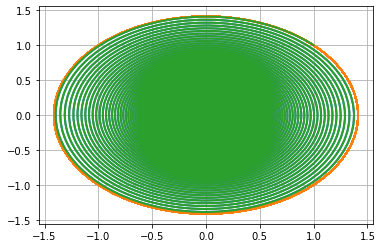

In [75]:
# z_egode = trajectory_ode(eg_os1ode, F, nFz, [1.0, 1.0])
# z_gradflow = trajectory_ode(eg_os0ode, F, nFz, [1.0, 1.0])
from scipy.integrate import odeint

z_egode1 = odeint(eg_os1ode, [1, 1], np.linspace(0, 1001, 10001), args=(F, nFz, 1e-2))
z_egode0 = odeint(eg_os0ode, [1, 1], np.linspace(0, 1001, 10001), args=(F, nFz, 1e-2))
print(z_egode0)
z_egdta = trajectory_dta(eg_dta, F, [1.0, 1.0])

# plot
fig, ax = plt.subplots()
ax.plot(z_egode1[:, 0], z_egode1[:, 1], linewidth=2.0)
ax.plot(z_egode0[:, 0], z_egode0[:, 1])
ax.plot(z_egdta[:, 0], z_egdta[:, 1], linewidth=2.0)
# ax.plot(z_gradflow[:,0], z_gradflow[:,1], linewidth=2.0)
plt.grid(visible=True)
plt.show()


[0.         0.15175645 0.30276984 ... 0.79672333 0.79670335 0.79636759] [0.         0.15175645 0.30276984 ... 1.47000219 1.47006746 1.46421161]


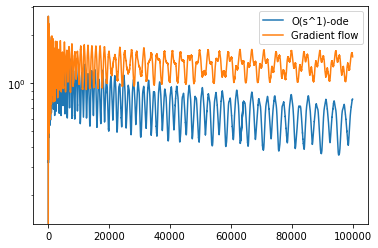

In [97]:
# Get index to sample ODE at uniform intervals
idx = np.linspace(0, len(z_egode1) - 1, num=len(z_egdta)).astype(int)

diff1 = np.sqrt(((z_egdta - z_egode1[idx]) ** 2).sum(axis=1))
diff0 = np.sqrt(((z_egdta - z_egode0[idx]) ** 2).sum(axis=1))

fig, ax = plt.subplots()
print(diff1, diff0)
ax.plot(np.arange(len(diff1)), diff1, label="O(s^1)-ode")
ax.plot(np.arange(len(diff0)), diff0, label="Gradient flow")
# print(diff0)
ax.set_yscale("log")
ax.legend()


In [77]:
def G(z):
    return np.array([z[1] ** 3, -z[0] ** 3])


def n_G(z):
    return np.array([[0, 3 * z[1] ** 2], [-3 * z[0] ** 2, 0]])


def n2_G(z):
    return np.array([[[0, 0], [-6 * z[0], 0]], [[0, 6 * z[1]], [0, 0]]])


In [90]:
# Using G loss
s = 1e-1
z_egode2 = odeint(eg_os2ode, [1, 1], np.linspace(0, 100, 10001), args=(G, n_G, n2_G, s))
z_egode1 = odeint(eg_os1ode, [1, 1], np.linspace(0, 100, 10001), args=(G, n_G, s))
z_egode0 = odeint(eg_os0ode, [1, 1], np.linspace(0, 100, 10001), args=(G, n_G, s))
z_egdta  = trajectory_dta(eg_dta, G, [1,1], lr=s)

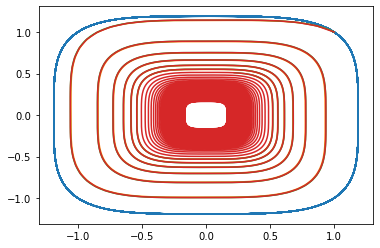

In [91]:
fig, ax = plt.subplots()
ax.plot(z_egode0[:,0], z_egode0[:,1])
ax.plot(z_egode1[:,0], z_egode1[:,1])
ax.plot(z_egode2[:,0], z_egode2[:,1])
ax.plot(z_egdta[:,0], z_egdta[:,1])

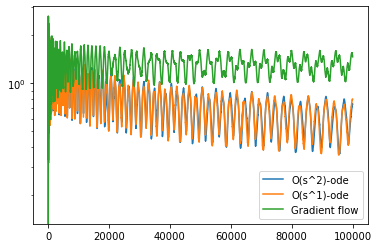

In [95]:

diff2 = np.sqrt(((z_egdta - z_egode2[idx]) ** 2).sum(axis=1))
diff1 = np.sqrt(((z_egdta - z_egode1[idx]) ** 2).sum(axis=1))
diff0 = np.sqrt(((z_egdta - z_egode0[idx]) ** 2).sum(axis=1))

fig, ax = plt.subplots()
# print(diff1, diff0)
ax.plot(np.arange(len(diff2)), diff2, label="O(s^2)-ode")
ax.plot(np.arange(len(diff1)), diff1, label="O(s^1)-ode")
ax.plot(np.arange(len(diff0)), diff0, label="Gradient flow")
# print(diff0)
ax.set_yscale("log")
ax.legend()